# Introduction

According to the World Health Organization report, skin cancer is diagnosed in one out of three people worldwide. Furthermore, one in every five Americans will develop skin cancer during their lifetime, according to the Skin Cancer Foundation. Melanoma and non-melanoma skin cancers are the most common types. Worldwide, approximately two to three million non-melanoma skin cancers and 132,000 melanoma skin cancers are diagnosed each year.

According to the Journal of the American Academy of Dermatology’s most recent findings, nearly 85 million Americans were seen by a physician for at least one skin disease in 2013, leading to an estimated direct health care cost of `$`75 billion and an indirect lost opportunity cost of `$`11 billion.

Melanoma is the deadliest type of skin cancer. A melanoma cell tends to travel to other body parts, including the lungs, liver, spleen, or brain. Mainly, metastatic melanoma ranks third most typical origin of central nervous system (CNS) metastases. In particular, the advanced stage of melanoma can often cause brain metastasis, whose treatment requires radiation therapy and immunotherapy. Furthermore, melanoma accounts for almost 10 percent of brain metastasis. Melanoma is responsible for 10,000 deaths each year in the United States alone. These figures appear bleak, but detecting cancer at an early stage reduces the risks of death significantly. Melanoma can be cured in nearly 95 percent of cases if detected early. Thus, it is critical for early-stage diagnosis of skin cancer to prolong patient survival.

The dermatologist's experience limits the visual evaluation of dermatoscopic images (or manual dermatoscopy). Due to the subjectivity of human decision-making, besides considerable inter-class similarity in skin lesions and other confounding factors, this method is prone to mistakes. General diagnostic procedures for identifying skin cancer, such as the ABCD (Asymmetry, Border, Color, Diameter) rule or the 7-point checklist, can only guide the practitioner with certain rules of thumb. Medical professionals can misinterpret and misclassify the same dermatoscopic image sample as belonging to different kinds of skin cancer. Thus, an automated computational system needs to undertake large quantities of visual exploration using past data to imitate medical experts' expertise better and maybe outperform them too, i.e., a data-driven strategy.

With the current resurgence of interest in machine learning, deep learning, and neural networks, automated skin cancer classification has been an important topic of research. Therefore, I leveraged the power of deep Convolutional Neural Networks (CNN) for skin lesion classification. In this project, I investigate the classification performance of the EfficientNets on the ISIC-2019 dataset of dermatoscopic images.

# Project Goal

The project focuses on creating a model that can classify eight types of skin cancer from dermoscopic images. To optimize resource utilization, the project will be developed using a small dataset.

# Importing various libraries

In [1]:
!pip install -q tensorflow tensorflow_addons Augmentor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.8 MB/s eta 0:00:00


In [7]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from scipy import fft

import os
import pathlib

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.color import rgb2gray
import seaborn as sns
sns.set_style('darkgrid')

import Augmentor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import sklearn.metrics as metrics

%matplotlib inline

# Dataset : ISIC 2019

## Introduction

The goal for ISIC 2019 is to classify dermoscopic images among nine different diagnostic categories.\
Total of 25,331 images are available for training across 8 different categories. 

* melanoma (MEL)
* melanocytic nevus (NV)
* Basal cell carcinoma (BCC)
* actinic keratosis(AK)
* benign keratosis(BKL)
* dermatofibroma(DF)
* vascular lesion (VASC)
* Squamous cell carcinoma(SCC)

This dataset contains images of size 600 × 450 and 1024 × 1024. 

Two tasks will be available for participation: 
1.   classify dermoscopic images without meta-data, and
2.   classify images with additional available meta-data.



## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/isic/ISIC - 2019/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/isic/ISIC - 2019/test")

## Visualization

In [ ]:
class_names = os.listdir('/content/drive/MyDrive/isic/ISIC - 2019/train')
num_classes = len(class_names)
class_names

['Actinic keratosis',
 'Basal cell carcinoma',
 'Benign keratosis',
 'Dermatofibroma',
 'Melanocytic nevus',
 'Melanoma',
 'Squamous cell carcinoma',
 'Vascular lesion']

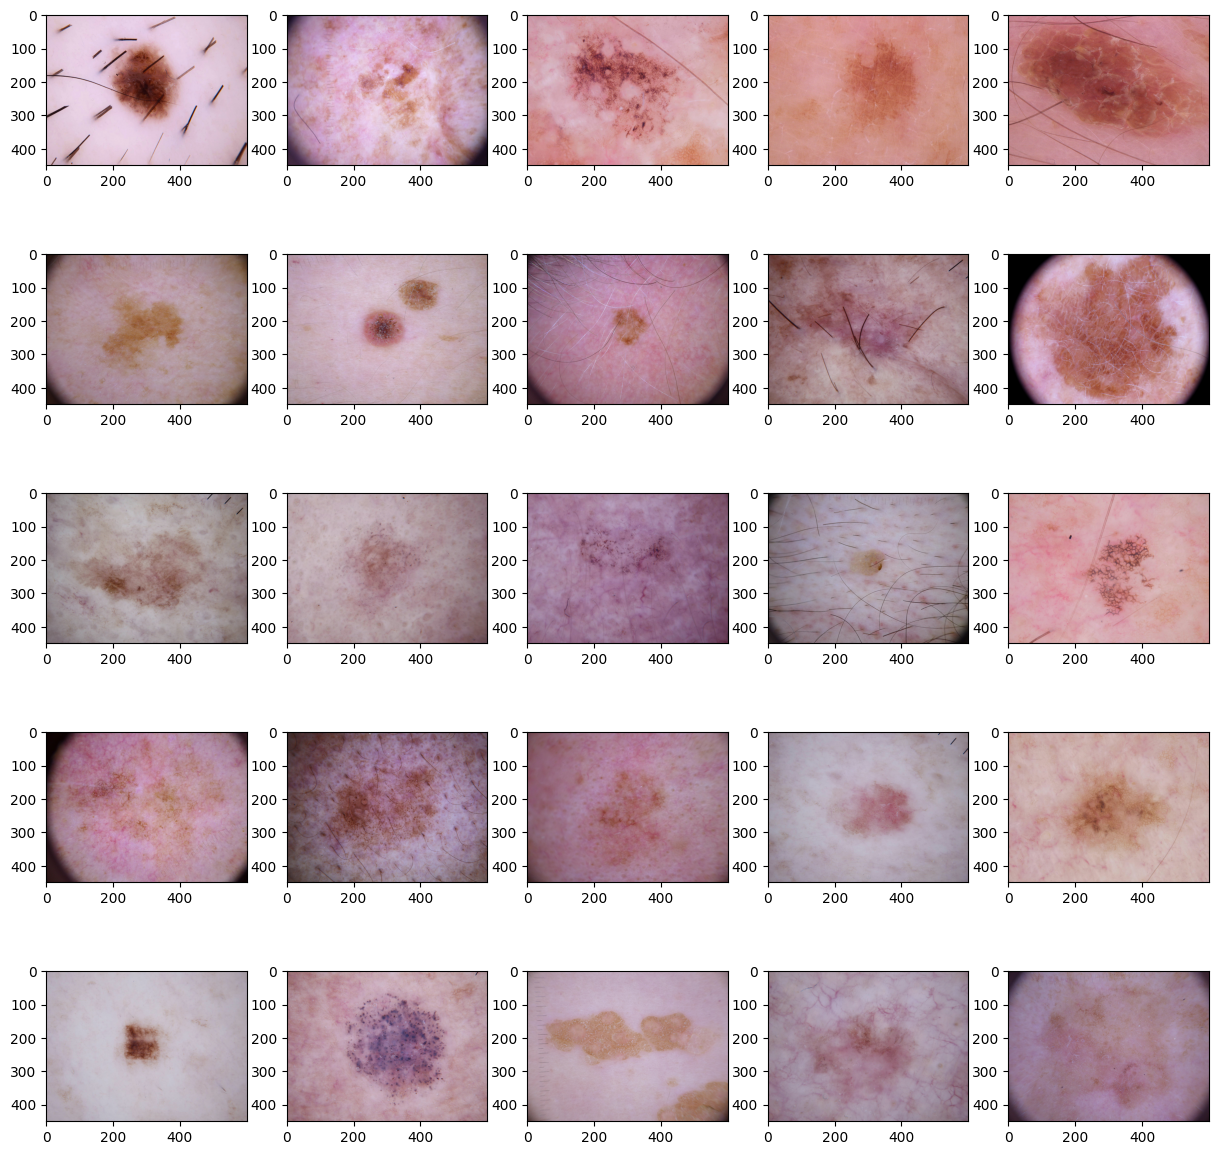

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
ax = ax.flatten()

for i in range(len(ax)):
    ax[i].imshow(np.asarray(Image.open(train_img_paths[i])), cmap=plt.get_cmap('gray'))

## EDA

Loads an example image, prints the data types, and dimensions of the image object

In [ ]:
# Open an example image file
example_image = Image.open(train_img_paths[0])

# Convert the image to a NumPy array
example_image = np.asarray(example_image)

# prints the data types and dimensions of the image object
print('The image object is ' + str(type(example_image)))
print('The pixel values are of type ' + str(type(example_image[0,0,0])))
print('Shape of image object = ' + str(example_image.shape))

The image object is <class 'numpy.ndarray'>
The pixel values are of type <class 'numpy.uint8'>
Shape of image object = (450, 600, 3)


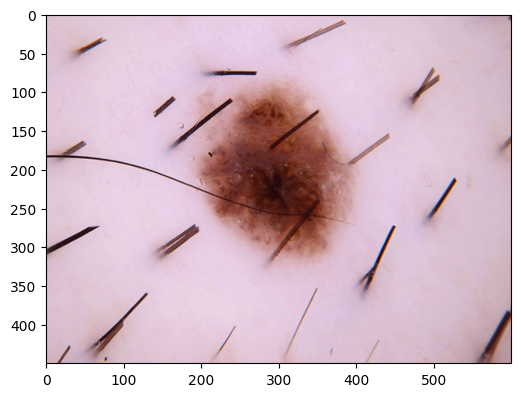

In [ ]:
fig, ax = plt.subplots( figsize=(6, 6))
_ = ax.imshow(example_image)

Display the 3 color channels of the image

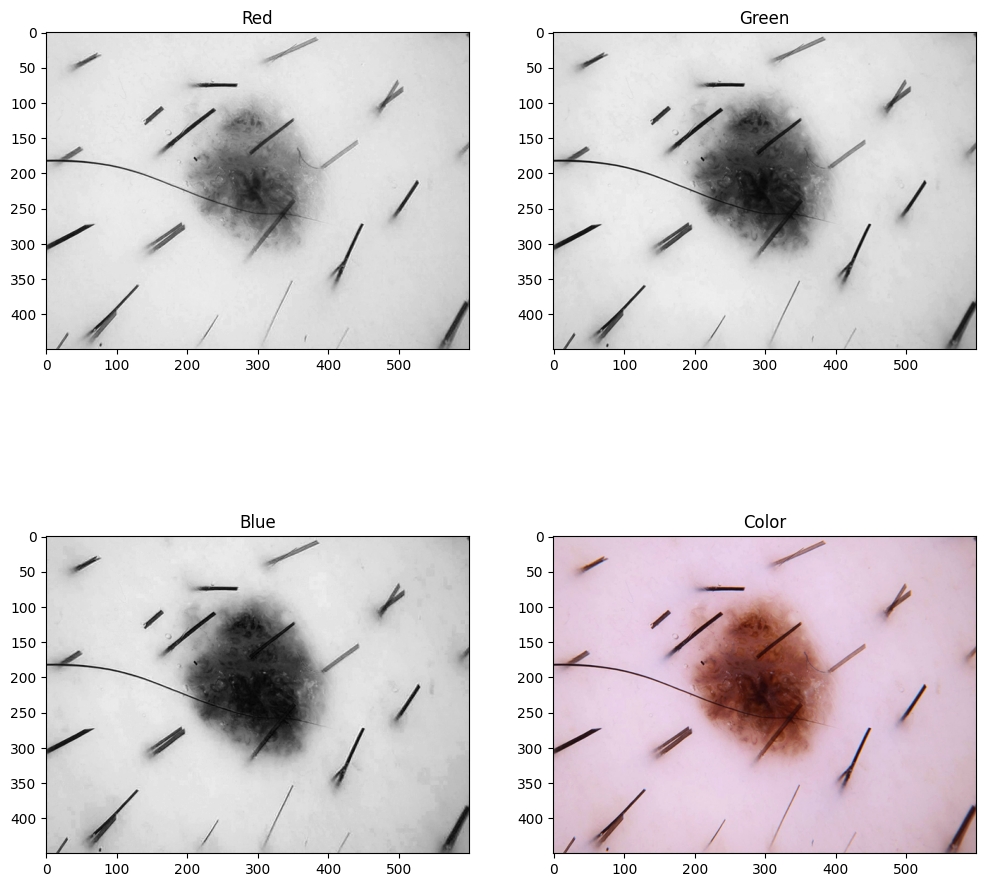

In [ ]:
def plot_3_color_channels(img):
    '''Function plots the three color channels of the image along with the complete image'''
    fig, ax = plt.subplots(2,2, figsize=(12, 12))
    ax = ax.flatten()
    ## Complete the code below
    titles=['Red','Green','Blue','Color']
    for i in range(3):
        ax[i].imshow(img[:,:,i], cmap=plt.get_cmap('gray'))
        ax[i].set_title(titles[i])
    ax[3].imshow(img)
    ax[3].set_title(titles[3])

plot_3_color_channels(example_image)

### Statistical Properties of an Image  

Histograms of the three color channels of the image along with the cumulative distributions

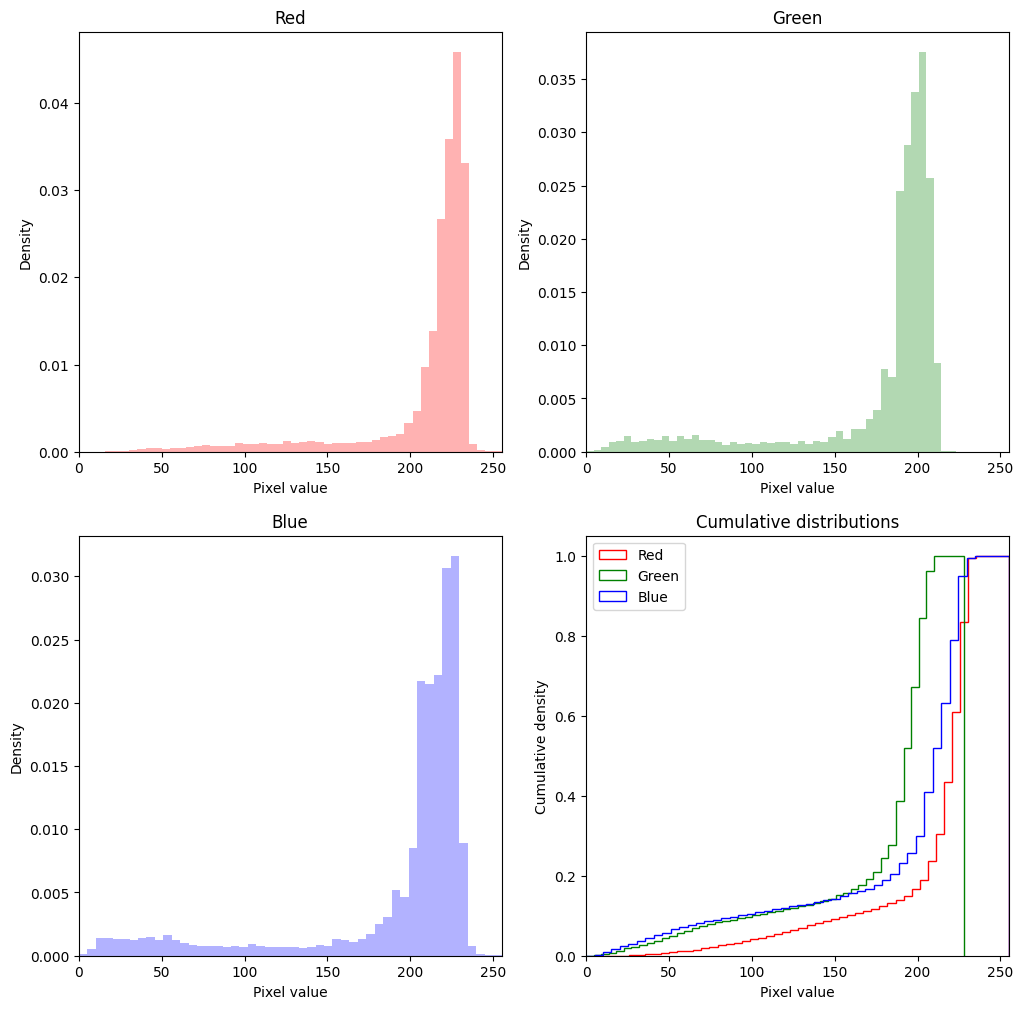

In [ ]:
def plot_image_distributions(img, xlim=(0,255)):
    '''Function plots histograms of the three color channels of the image along
    with the cumulative distributions'''
    fig, ax = plt.subplots(2,2, figsize=(12, 12))
    ax = ax.flatten()
    titles=['Red','Green','Blue']
    for i in range(3):
        ax[i].hist(img[:,:,i].flatten(), bins=50, density=True, color=titles[i], alpha=0.3)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel('Pixel value')
        ax[i].set_ylabel('Density')
        ax[i].set_xlim(xlim)
        ax[3].hist(img[:,:,i].flatten(), bins=50, density=True, cumulative=True, color=titles[i], histtype='step', label=titles[i])
        ax[3].set_xlim(xlim)
    ax[3].set_title('Cumulative distributions')
    ax[3].set_xlabel('Pixel value')
    ax[3].set_ylabel('Cumulative density')
    plt.legend(loc='upper left')

plot_image_distributions(example_image)

Histograms of a gray scale image along with the cumulative distribution

(450, 600)


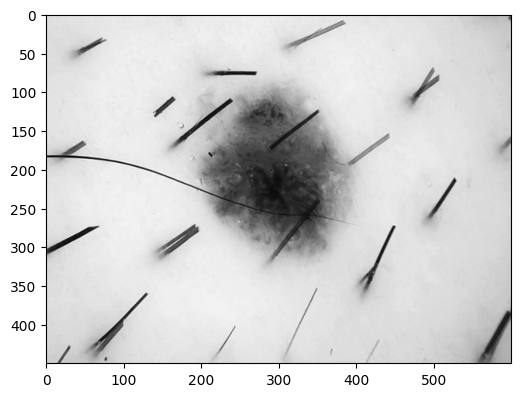

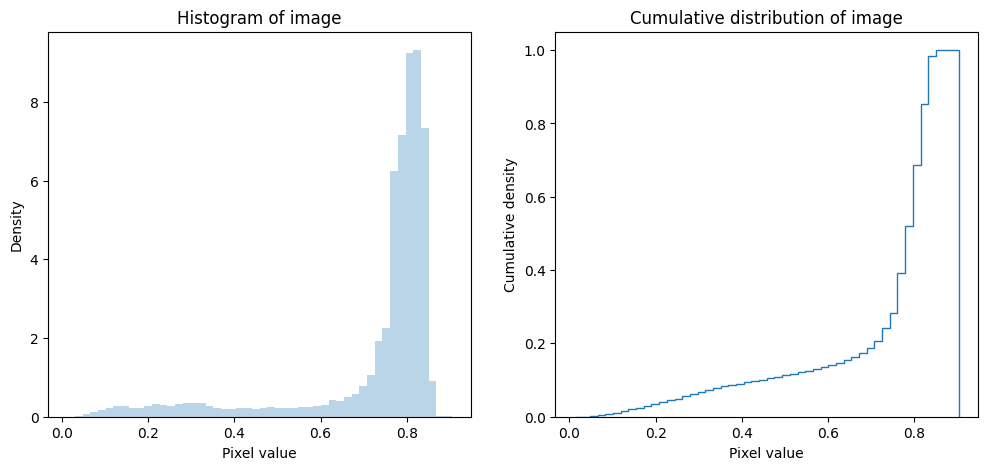

In [ ]:
def plot_grayscale(img):
    fig, ax = plt.subplots( figsize=(6, 6))
    _=ax.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

def plot_gray_scale_distribution(img):
    '''Function plots histograms a gray scale image along
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title('Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')
    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title('Cumulative distribution of image')
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density')
    plt.show()

example_gray_scale = rgb2gray(example_image)
print(example_gray_scale.shape)

plot_grayscale(example_gray_scale)
plot_gray_scale_distribution(example_gray_scale)

## Histogram Equalization

In [ ]:
def test_equalize(img, func):
    img_equalized = eval(func)(img)
    plot_grayscale(img_equalized)
    plot_gray_scale_distribution(img_equalized)
    return img_equalized

Histogram equalization


For function exposure.equalize_hist


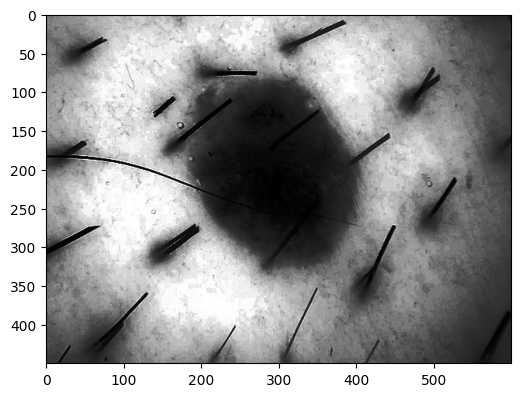

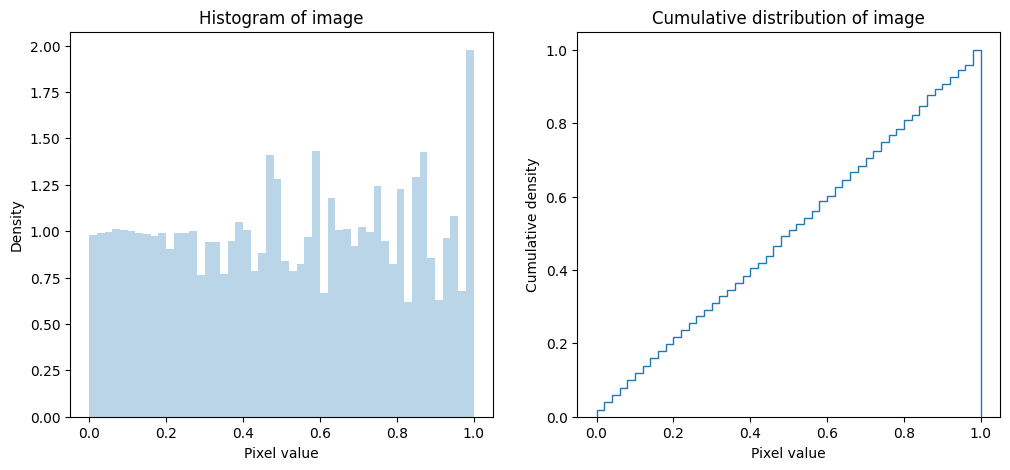

In [ ]:
print('\nFor function ' + 'exposure.equalize_hist')
example_gray_scale_equalized = test_equalize(example_gray_scale, 'exposure.equalize_hist')

Adaptive histogram equalization


For function exposure.equalize_adapthist


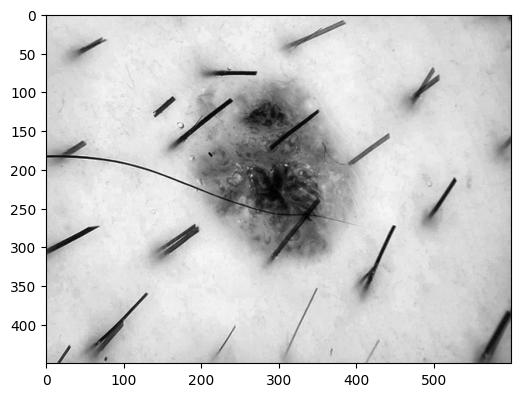

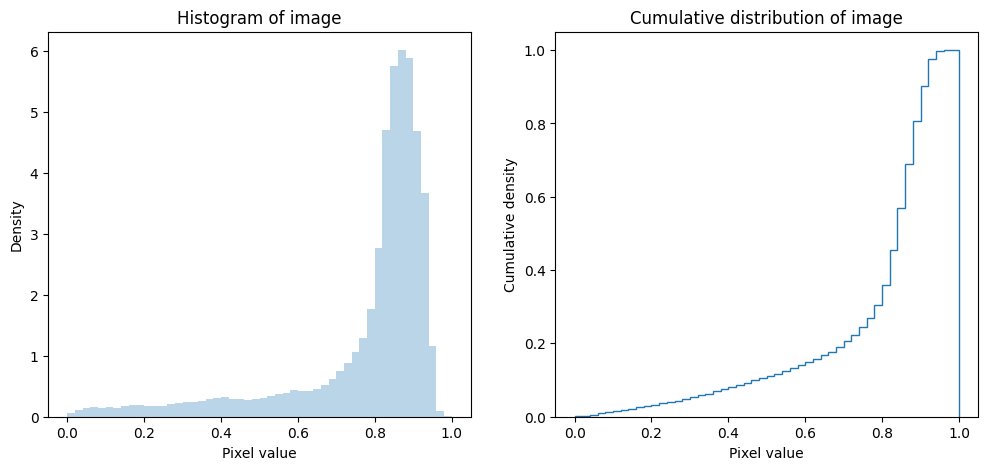

In [ ]:
print('\nFor function ' + 'exposure.equalize_adapthist')
example_gray_scale_equalized = test_equalize(example_gray_scale, 'exposure.equalize_adapthist')

### Binary Image

Threshold = 0.4581592156862745
(450, 600)


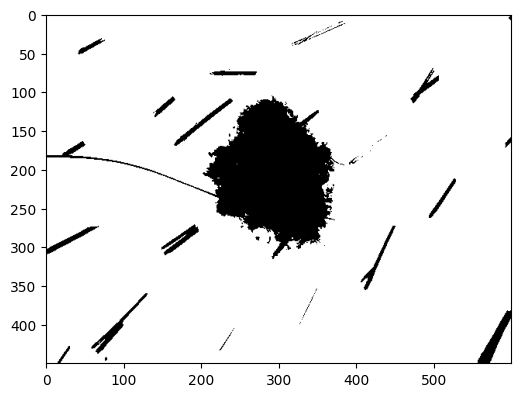

Threshold = 0.5
(450, 600)


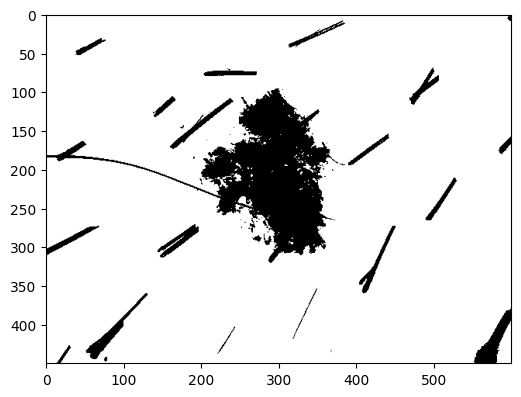

In [ ]:
def transform2binary(img, threshold=0.5):
    '''
    Function converts a gray scale or color image to binary values.
        Args:
            img - a color or gray scale image file
            threshold = the threshold value on a 0-1 scale. Pixel values >= threshold are set to 1, else 0
        Returns:
            Binary 2d image as a numpy array
    '''
    ## Make sure to use a copy to prevent weird bugs that
    ## that are nearly impossible to track down
    img = np.copy(img)

    ## Complete the code below
    ## Convert to gray scale if needed
    if len(img.shape)==3: img = rgb2gray(img)


    ## Convert threshold value
    threshold = threshold * (np.max(img) - np.min(img)) + np.min(img)
    print('Threshold = ' + str(threshold))
    ## threshold
    return np.where(img >= threshold, 1, 0)

for img in [example_image, example_gray_scale_equalized]:
    example_binary = transform2binary(img, threshold=0.5)
    print(example_binary.shape)
    plot_grayscale(example_binary)

### Power spectrum

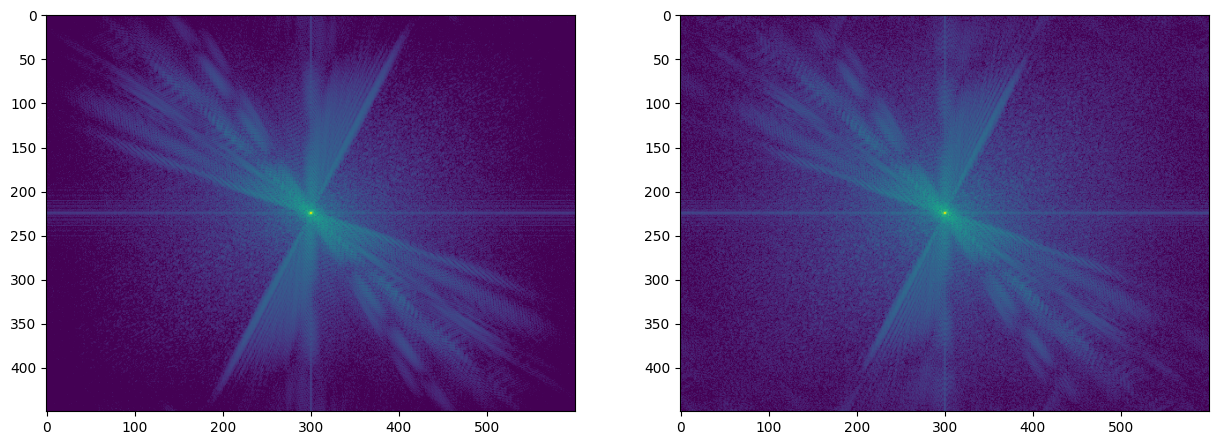

In [ ]:
image_power = lambda x: np.square(np.abs(fft.fftshift(fft.fft2(x))))

def plot_2d_fft(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    im = ax[0].imshow(image_power(img1), norm=LogNorm(vmin=5))
    im = ax[1].imshow(image_power(img2), norm=LogNorm(vmin=5))
    plt.show()
    plt.show()

plot_2d_fft(example_gray_scale, example_gray_scale_equalized)

# Data Preparation for Modeling

## Analysing the class imbalance of the data

Data imbalance and data limitation in skin disease datasets are common problems which make the tasks of skin cancer classification difficult. In fact, benign lesions account for the majority of data in many skin disease datasets. Meanwhile, many skin disease datasets have large inequities in the number of samples among different skin disease classes. Only the common skin diseases, such as BCC, SCC, and melanoma, are included in the majority of skin disease datasets. Other skin cancer diseases (such as appendiceal carcinomas and cutaneous lymphoma) are relatively rare in these datasets, making it difficult for algorithms to classify them correctly. Besides, the skin lesions in most of the current datasets are from fair-skinned people, with only a few from dark-skinned people. It has been demonstrated that deep learning frameworks that have been validated for skin cancer diagnosis in fair-skinned people are more likely to misdiagnose those with different races or ethnicity. At the same time, the quantity of skin disease images is also relatively restricted. For example, ISIC-2020 is the dataset with the largest number images so far, with about 30,000 skin disease images. Although large amounts of skin disease images can be obtained from websites or medical institutions without any diagnosis information, labeling them takes professional knowledge and can be extremely challenging and time-consuming. Sufficient labeled data are a requirement for training a reliable model. When only a limited number of images are provided, overfitting is more likely to occur. As a result, for the skin cancer classification task, a considerable amount of labeled data is required.

total training image count = 21491 

-------------------------------------
Class name =  Actinic keratosis
count      =  716
proportion =  0.033316271927783726
-------------------------------------
Class name =  Basal cell carcinoma
count      =  2820
proportion =  0.1312177190451817
-------------------------------------
Class name =  Benign keratosis
count      =  2215
proportion =  0.10306639988832535
-------------------------------------
Class name =  Dermatofibroma
count      =  206
proportion =  0.00958540784514448
-------------------------------------
Class name =  Melanocytic nevus
count      =  10979
proportion =  0.5108650132613652
-------------------------------------
Class name =  Melanoma
count      =  3812
proportion =  0.17737657624121725
-------------------------------------
Class name =  Squamous cell carcinoma
count      =  541
proportion =  0.025173328370015357
-------------------------------------
Class name =  Vascular lesion
count      =  202
proportion =  0.009399

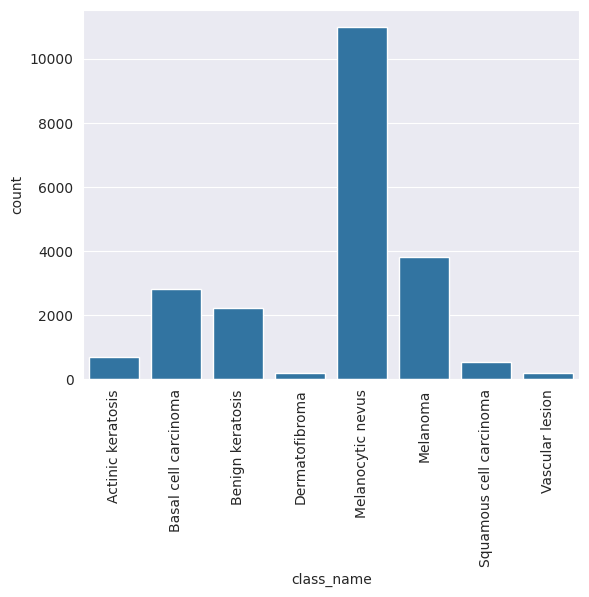

In [ ]:
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

* Majority class: Melanocytic nevus 
* Moderate class: Basal cell carcinoma, Benign keratosis, Melanoma 
* Extreme class: Actinic keratosis, Dermatofibroma, Squamous cell carcinoma, Vascular lesion

Here are three strategies and techniques I can employ to manage imbalance in datasets:
1. Resampling Methods\
Oversampling Minority Class: Increase the number of instances in the minority class by duplicating them or by synthesizing new examples using techniques like SMOTE (Synthetic Minority Over-sampling Technique). Note, for image data, SMOTE may not be ideal; instead, consider data augmentation techniques. \
Undersampling Majority Class: Decrease the number of instances in the majority class to balance the dataset. This can lead to loss of potentially valuable data, so it should be used cautiously.

2. Data Augmentation\
Enhance the size and diversity of the minority class by applying transformations like rotation, scaling, flipping, and color variation. This helps in creating a more balanced dataset and also in improving the model's robustness.

3. Modify Class Weights\
Adjust the model’s loss function to penalize misclassifications of the minority class more than the majority class. Most machine learning frameworks allow you to set class weights directly in the model configuration.

In [ ]:
class_weights = [sum(all_count) / (8 * _) for _ in all_count]
class_weight = {}
for i in range(len(class_weights)):
  class_weight[i] = class_weights[i]
class_weight

{0: 4.991680887372014, 
1: 0.951879271070615,
2: 3.6933396464646466,
3: 0.2456024349286314,
4: 0.7028171552138395,
5: 12.773471615720524,
6: 12.829495614035087,
7: 1.2082300702189177}


Based on the experimental results, it is evident that method 2 exhibits the most favorable performance among the three methods.

Due to limited computational resources and a highly imbalanced dataset, I allocate 1000 elements per class.

In [ ]:
for i in class_names:
    p = Augmentor.Pipeline('/content/drive/MyDrive/ISIC - 2019/train/' + i, output_directory='/content/drive/MyDrive/ISIC - 2019/output/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 586 image(s) found.
Output directory set to /content/drive/MyDrive/ISIC - 2019/output/Squamous cell carcinoma.Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7905E2D0F640>: 100%|██████████| 1000/1000 [00:19<00:00, 50.45 Samples/s]
Initialised with 3073 image(s) found.
Output directory set to /content/drive/MyDrive/ISIC - 2019/output/Basal cell carcinoma.Processing <PIL.Image.Image image mode=RGB size=1024x1024 at 0x790531C9F7F0>: 100%|██████████| 1000/1000 [00:21<00:00, 47.40 Samples/s]
Initialised with 792 image(s) found.
Output directory set to /content/drive/MyDrive/ISIC - 2019/output/Actinic keratosis.Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x790531C37310>: 100%|██████████| 1000/1000 [00:22<00:00, 45.18 Samples/s]
Initialised with 11910 image(s) found.
Output directory set to /content/drive/MyDrive/ISIC - 2019/output/Melanocytic nevus.Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7

## Prepare train, validation and test data

In [4]:
batch_size = 8
img_height = 380
img_width = 380

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/ISIC - 2019/output/',
  seed=123,
  validation_split = 0.001,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/ISIC - 2019/train/',
  seed=123,
  validation_split = 0.07,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23401 files belonging to 8 classes.
Using 2340 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

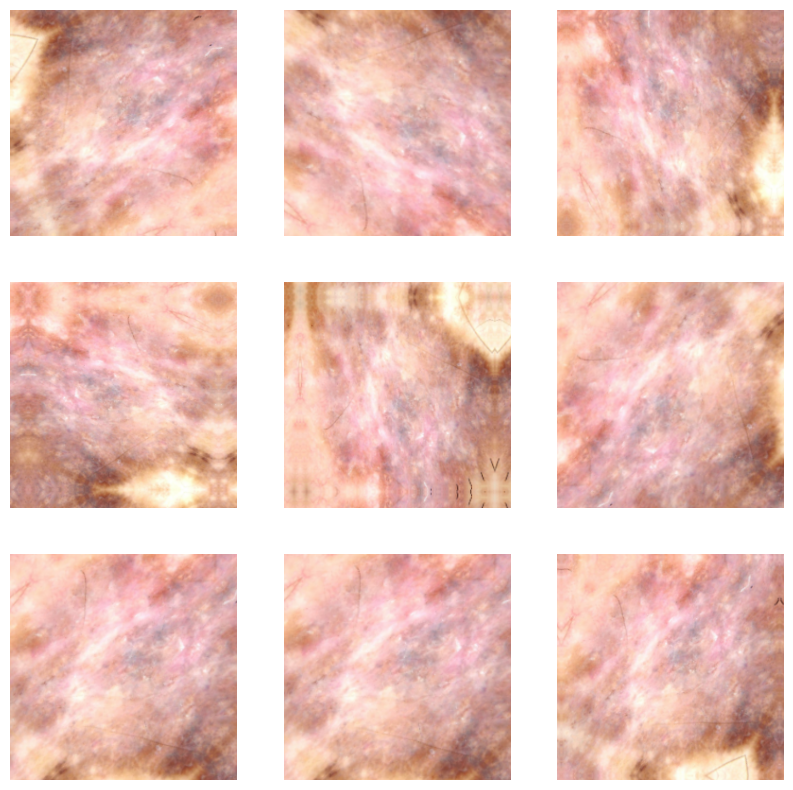

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model

The proposed model is implemented using a transfer learning mechanism for detecting skin cancer in dermoscopic images.

## Introduction: what is EfficientNet

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)
is among the most efficient models (i.e. requiring least FLOPS (Floating Point Operations Per Second) for inference) that reaches State-of-the-Art accuracy on both
imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which
reached near-SOTA with a significantly smaller model. By introducing a heuristic way to
scale the model, EfficientNet provides a family of models (B0 to B7) that represents a
good combination of efficiency and accuracy on a variety of scales. Such a scaling
heuristics (compound-scaling, for details see
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the
efficiency-oriented base model (B0) to surpass models at every scale, while avoiding
extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available
[here](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), where various
augmentation schemes and semi-supervised learning approaches are applied to further
improve the imagenet performance of the models. These extensions of the model can be used
by updating weights without changing model architecture.

## B0 to B7 variants of EfficientNet

Based on the [original paper](https://arxiv.org/abs/1905.11946) one might have the
impression that EfficientNet is a continuous family of models created by arbitrarily
choosing scaling factor in as Eq.(3) of the paper.  However, choice of resolution,
depth, and width are also restricted by many factors:

- Input Image Size:

| Model Variant | Image Size |  
| ------------- | ---------- |
| B0                | 224x224              |
| B1                | 240x240              |
| B2                | 260x260              |
| B3                | 300x300              |
| B4                | 380x380              |
| B5                | 456x456              |
| B6                | 528x528              |
| B7                | 600x600              |

- Depth and width: The building blocks of EfficientNet demands channel size to be
multiples of 8.

- Resource limit: Memory limitation may bottleneck resolution when depth
and width can still increase. In such a situation, increasing depth and/or
width but keep resolution can still improve performance.

As a result, the depth, width, and resolution of each variant of the EfficientNet models
are hand-picked and proven to produce good results, though they may be significantly
off from the compound scaling formula.
Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7,
instead of allowing arbitray choice of width / depth / resolution parameters.

## EfficientNet B4

The final model is finetuned with EfficientNetB4

As EfficientNet classifies images into 1000 classes, we need to change the last layer of the model so that it will classify the images into 8 classes.

In [2]:
from tensorflow.keras.applications import EfficientNetB4

In [5]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

71686520/71686520 [==============================] - 2s 0us/step


In [6]:
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 380, 380, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 380, 380, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 380, 380, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 380, 380, 3)          0         ['normalization[0

## Finetuning Model

The models were finetuned on Google Colab, which has T4 GPU. The EfficientNet variants suitable for fine-tuning on a Colab T4 GPU include EfficientNet B0 to B4. These variants are manageable within the GPU constraints typically found in Colab environments, making them practical choices for tasks such as image classification. While larger variants like B7 are technically feasible, they may not guarantee improved performance and could be more challenging to fine-tune due to higher computational demands. Therefore, it is recommended to use EfficientNet B0 to B4 for fine-tuning on a Colab T4 GPU.

The following batch size is determined by limited computational resources.

| Model Variant | Batch Size |  
| ------------- | ---------- |
| B0                | 32              |
| B1                | 32              |
| B2                | 32             |
| B3                | 16              |
| B4                | 8              |

### Tips for fine tuning EfficientNet

#### On unfreezing layers:

* The BatchNormalization layers need to be kept frozen. If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
* In some cases, it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.
* Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance.

####  Some other tips for utilizing EfficientNet:

* Larger variants of EfficientNet do not guarantee improved performance, especially for tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet chosen, the harder it is to tune hyperparameters.
* EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch, but not so much for transfer learning.
* Do not use the RMSprop setup as in the original paper for transfer learning. The momentum and learning rate are too high for transfer learning. It will easily corrupt the pretrained weight and blow up the loss. A quick check is to see if loss (as categorical cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same epoch. If so, the initial learning rate/momentum is too high.
* Smaller batch size benefit validation accuracy, possibly due to effectively providing regularization.

## Train on EfficientNetB4 (Base model)

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    data_augmentation,
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/25
1000/1000 [==============================] - 351s 172ms/step - loss: 2.5022 - accuracy: 0.2946 - val_loss: 1.7133 - val_accuracy: 0.3982
Epoch 2/25
1000/1000 [==============================] - 332s 141ms/step - loss: 1.9660 - accuracy: 0.3527 - val_loss: 1.4993 - val_accuracy: 0.4519
Epoch 3/25
1000/1000 [==============================] - 331s 140ms/step - loss: 1.7314 - accuracy: 0.4280 - val_loss: 1.3787 - val_accuracy: 0.5213
Epoch 4/25
1000/1000 [==============================] - 331s 140ms/step - loss: 1.6057 - accuracy: 0.4381 - val_loss: 1.3648 - val_accuracy: 0.4877
Epoch 5/25
1000/1000 [==============================] - 331s 140ms/step - loss: 1.5317 - accuracy: 0.4643 - val_loss: 1.2978 - val_accuracy: 0.5280
Epoch 6/25
1000/1000 [==============================] - 331s 140ms/step - loss: 1.4864 - accuracy: 0.4816 - val_loss: 1.2561 - val_accuracy: 0.5593
Epoch 7/25
1000/1000 [==============================] - 332s 141ms/step - loss: 1.4119 - accuracy: 0.4978 - val_

## Final Model

In [ ]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Create the model
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(momentum=0.99),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(momentum=0.99),
    Dropout(0.7),
    Dense(num_classes, activation='softmax')
])

model.compile(tf.keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.01),
               loss=SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

# Train the model
epochs = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight
)

Epoch 1/40
1000/1000 [==============================] - 351s 172ms/step - loss: 2.3022 - accuracy: 0.3146 - val_loss: 1.7233 - val_accuracy: 0.3782
Epoch 2/40
1000/1000 [==============================] - 332s 141ms/step - loss: 1.9440 - accuracy: 0.3447 - val_loss: 1.4393 - val_accuracy: 0.4139
Epoch 3/40
1000/1000 [==============================] - 331s 140ms/step - loss: 1.7214 - accuracy: 0.4208 - val_loss: 1.3987 - val_accuracy: 0.5213
Epoch 4/40
1000/1000 [==============================] - 331s 140ms/step - loss: 1.6257 - accuracy: 0.4331 - val_loss: 1.3248 - val_accuracy: 0.4397
Epoch 5/40
1000/1000 [==============================] - 331s 140ms/step - loss: 1.5137 - accuracy: 0.4643 - val_loss: 1.2978 - val_accuracy: 0.5180
Epoch 6/40
1000/1000 [==============================] - 331s 140ms/step - loss: 1.4564 - accuracy: 0.4816 - val_loss: 1.2561 - val_accuracy: 0.5293
Epoch 7/40
1000/1000 [==============================] - 332s 141ms/step - loss: 1.4219 - accuracy: 0.4978 - val_

# Model Result

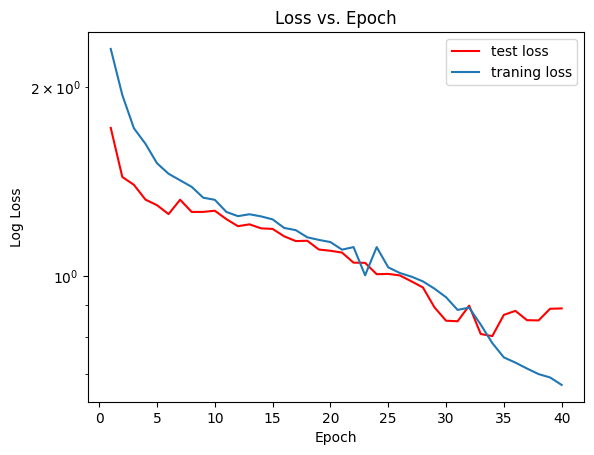

In [29]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'test loss')
    plt.plot(x, train_loss, label = 'traning loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()
    
plot_loss(history)  

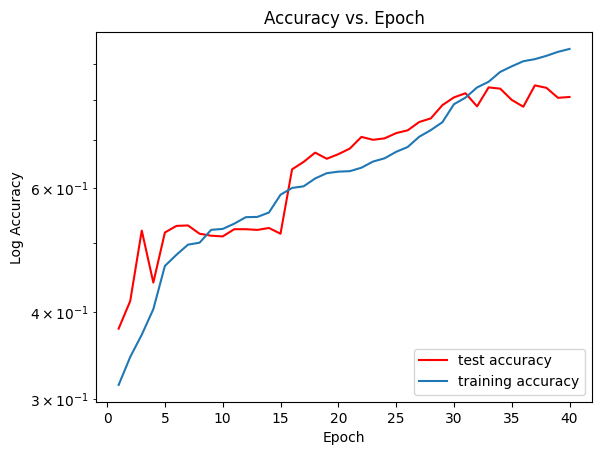

In [32]:
def plot_accuracy(history):
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'test accuracy')
    plt.plot(x, train_acc, label = 'training accuracy')  
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Log Accuracy')
    plt.title('Accuracy vs. Epoch')  
    plt.legend(loc='lower right')
    plt.show()   

plot_accuracy(history)  

## Evaluation Metrics
Evaluating a model’s performance is necessary since it gives an idea of how close the model’s predicted outputs are to the corresponding expected outputs. 
The evaluation metrics are used to evaluate a model’s performance. \
However, the evaluation metrics differ with the types of models. 
The types of models are classification and regression. 
Regression refers to the problem that involves predicting a numeric value.
Classification refers to the problem that involves predicting a discrete value. 
The regression problem uses the error metric for evaluating the models. Unlike the regression problem model, the classification problem uses the accuracy metric for
evaluation. 

Since our motive is to classify the cancerous cell,
we used accuracy, f1 score, precision, and Recall for our
evaluation metric. 

* Precision : When the model predicts positive, it should
be specified that how much the positive values are
correct. Precision is used when the False Positives are
high. For skin cancer classification, if the model gives
low precision, then many non-cancerous images will be
detected as cancerous; for high precision, it will ignore
the False positive values by learning with false alarms.
Here TP refers to True Positive values and FP refers
to False Positive values. 
* Recall : The metric recall is the opposite of Precision.
The precision is used when the false negatives (FN) are
high. In the aggressive detection classification problem,
if the model gives low recall, then many cancerous cells
will be said as non-cancerous cells; for high recall, it will
ignore the false negative values by learning with false
alarms. 
* F1 score: F1 score combines precision and recall and provides
an overall accuracy measurement of the model. The value of
the F1 score lies between 1 and 0. If the predicted value
matches with the expected value, then the f1 score gives 1,
and if none of the values matches with the expected value, it
gives 0. 

In [ ]:
test_images = [np.asarray(Image.open(test_img_path)) for test_img_path in test_img_paths]
y_true = [test_img_path.split('/test')[1].split('/')[0] for test_img_path in test_img_paths]
y_pred = model.predict(test_images)

In [1]:
clr = classification_report(y_true, y_pred, target_names=class_names, digits= 4)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

      Actinic keratosis     0.8754    0.7986    0.7869       716
   Basal cell carcinoma     0.8943    0.7954    0.7949      2820
       Benign keratosis     0.7968    0.7928    0.7948      2215
         Dermatofibroma     0.7904    1.0000    0.7952       206
      Melanocytic nevus     0.6986    0.7959    0.7973     10979
               Melanoma     0.7930    0.7979    0.7954      3812
Squamous cell carcinoma     1.0000    0.7982    0.7991       541
        Vascular lesion     1.0000    0.7950    0.7975       202

               accuracy                         0.7960     21491
              macro avg     0.7811    0.8217    0.7951     21491
           weighted avg     0.7861    0.7960    0.7960     21491



# Discussion and Futher Work

## Conclusion

Since the death rate due to skin cancer increases day by day, it is necessary to address this global public health issue. 
The outstanding performance of deep convolution models on image datasets can be utilized for skin cancer detection. 
However, using the deep learning models, a different problem has a different process to solve. \
This report will help the medical sector distinguish skin cancer from different skin lesions accurately. \
Eight classes of skin lesions have been classified using EfficientNetB4. \
Finally, the performance of the models is evaluated using evaluation metrics such as precision, recall, f1-score, and accuracy.

## Key highlights & learnings:

* The capability of transfer learning is a critical enabler for success in object classification tasks.
* Improvements in dataset balance can lead to significant improvements in model performance.
* I have used several finetuning techniques in this project which have been an extremely fruitful learning experience.

## Data Imbalance and Data Limitation inSkin Disease Datasets

The size of the dataset and model complexity justifies this observed performance trend. With models having more model complexity, there is a higher probability of attaining a better performance metric. However, at the same time, they are more prone to overfitting. ISIC provides a small number of photos for a deep learning dataset in comparison to the benchmark ImageNet collection of 1 million images. 
Data imbalance and data limitation in skin disease datasets are common problems in the skin cancer classiﬁcation tasks. 

In fact, benign lesions account for the majority of data in many skin disease datasets. Meanwhile, many skin disease datasets havelarge inequities in the number of samples among different skin disease classes. Only the common skin diseases, such as BCC,SCC, and melanoma, are included in the majority of skin disease datasets. Other skin cancer diseases (such as appendicealcarcinomas and cutaneous lymphoma) are relatively rare inthese datasets, making it difﬁcult for algorithms to classify them correctly. Besides, the skin lesions in most of the current datasets are from fair-skinned people, with only a few from dark-skinned people. It has been demonstrated that deep learning frameworks that have been validated for skin cancer diagnosis in fair-skinned people are more likely tomisdiagnose those with different races or ethnicity. 

At the same time, the quantity of skin disease images is alsorelatively restricted. For example, ISIC-2020 is the dataset with the largest number images so far, with about30,000 skin disease images. Although large amounts of skin disease images can be obtained from websites or medical institutions without any diagnosis information, labeling them takes professional knowledge and can be extremely challenging and time-consuming. What is more, sufﬁcient labeled data are arequirement for training a reliable model. When only a limited number of images are provided, overﬁtting is more likely to occur. 

As a result, for the skin cancer classiﬁcation task, a considerable amount of labeled data is required. Generative adversarial networks (GAN) are widely thought tobe a preferable alternative, as they can generate artiﬁcial data tocompensate for data imbalance in terms of positive and negative proportions, rare cases, and different people. designed a dataaugmentation method based on generative adversarial networksto address the shortcomings of skin lesion images in melanomadetection. 

## Future Work

* I would like to try with more pretrained models and finetuning methods to further improve model performance.
* Currently, I have only trained the model on some of ISIC 2019 - I would like to broadbase to include more images from both perspectives - training and testing - to make the model more generalized. This would also require significant work in data collection.